In [1]:
import pymssql
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import numpy as np
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

In [2]:
imputer = KNNImputer()

In [3]:
#First we query in the data from the SQL database and pre-process it for machine learning.
database = "group1"
table = "dbo.capstone_sql_table"
username = "group1user"
password  = "everythingIsAwesome!"
server = "database2108.database.windows.net"

conn = pymssql.connect(server,username, password,database)

cursor = conn.cursor()

In [4]:
query = 'select * from capstone_sql_table'
rawDF = pd.read_sql(query, conn)

In [5]:
orig_shape = rawDF.shape
orig_shape

(6727, 19)

In [6]:
rawDF.dropna(thresh=orig_shape[1]/2, inplace=True)

rawDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5222 entries, 0 to 6725
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   year                                                                 5222 non-null   object
 1   country                                                              5222 non-null   object
 2   Stocks traded, total value (% of GDP)                                2143 non-null   object
 3   Inflation, consumer prices (annual %)                                4900 non-null   object
 4   Stocks traded, turnover ratio of domestic shares (%)                 1853 non-null   object
 5   Tax revenue (% of GDP)                                               3076 non-null   object
 6   GDP per capita (current US$)                                         5203 non-null   object
 7   Central governm

In [7]:
rawDF.drop(columns=['Poverty headcount ratio at national poverty lines (% of population)', 'Income share held by highest 10%', 'Central government debt, total (% of GDP)', 'International migrant stock, total', 'Stocks traded, turnover ratio of domestic shares (%)'], inplace=True)

rawDF['lead_Unemp'] =  rawDF.sort_values(by = ['year'], ascending = True).groupby(['country'])['Unemployment, total (% of total labor force) (modeled ILO estimate)'].shift(-1)
unemp_DF = rawDF[rawDF['lead_Unemp'].notna()]
unemp_DF = unemp_DF.drop(columns = ['Gini index (World Bank estimate)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)'])

In [8]:
unemp_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4889 entries, 0 to 6724
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   year                                         4889 non-null   object
 1   country                                      4889 non-null   object
 2   Stocks traded, total value (% of GDP)        2073 non-null   object
 3   Inflation, consumer prices (annual %)        4586 non-null   object
 4   Tax revenue (% of GDP)                       2954 non-null   object
 5   GDP per capita (current US$)                 4872 non-null   object
 6   Broad money (% of GDP)                       4234 non-null   object
 7   Total reserves (includes gold, current US$)  4557 non-null   object
 8   Exports of goods and services (% of GDP)     4571 non-null   object
 9   timestamp                                    4889 non-null   object
 10  lead_Unemp  

In [9]:
impute_unemp = unemp_DF.drop(columns=['country','year','timestamp'])

In [10]:
for col in impute_unemp.columns:
    impute_unemp[col] = impute_unemp[col].apply(pd.to_numeric)
    
impute_unemp.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP),lead_Unemp
count,2073.000000,4586.000000,2954.000000,4872.000000,4234.000000,4.557000e+03,4571.000000,4889.000000
mean,30.916458,25.998941,17.390225,10228.386722,51.923468,4.003017e+10,39.625192,7.923295
std,64.270168,402.051809,8.135295,16030.887631,41.513152,1.923207e+11,28.673196,6.167221
min,0.000315,-18.108630,0.043495,22.795345,2.857408,0.000000e+00,0.005377,0.110000
25%,1.572152,1.922037,12.380724,923.522029,24.457249,4.812868e+08,21.821351,3.600000
50%,8.330101,4.171705,16.623822,3155.565060,41.620483,2.906843e+09,33.282038,6.210000
75%,35.905775,8.715352,21.908565,11936.752279,65.419809,1.952691e+10,49.526244,10.350000
max,952.667323,23773.131774,149.283510,118823.648369,403.379573,3.900039e+12,228.993771,37.970000


In [11]:

# Next, we standardize the data frame to prepare it for KNN imputation.
mean_list = []
std_list = []
from scipy import stats
for col in impute_unemp.columns:
    mean = impute_unemp[col].mean()
    mean_list.append(mean)
    std = impute_unemp[col].std()
    std_list.append(std)
    impute_unemp[col] = (impute_unemp[col] - mean)/std
impute_unemp.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP),lead_Unemp
count,2.073000e+03,4.586000e+03,2.954000e+03,4.872000e+03,4.234000e+03,4.557000e+03,4.571000e+03,4.889000e+03
mean,6.325272e-16,2.392602e-17,1.703670e-16,-1.794769e-16,-1.100311e-15,-9.580638e-16,1.246675e-15,-9.995641e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.810341e-01,-1.097062e-01,-2.132280e+00,-6.366205e-01,-1.181940e+00,-2.081428e-01,-1.381772e+00,-1.266907e+00
25%,-4.565774e-01,-5.988508e-02,-6.157737e-01,-5.804335e-01,-6.616269e-01,-2.056403e-01,-6.209228e-01,-7.010119e-01
50%,-3.514283e-01,-5.428961e-02,-9.420713e-02,-4.411996e-01,-2.481860e-01,-1.930283e-01,-2.212224e-01,-2.778067e-01
75%,7.763037e-02,-4.298846e-02,5.553997e-01,1.065671e-01,3.251100e-01,-1.066097e-01,3.453069e-01,3.934843e-01
max,1.434182e+01,5.906486e+01,1.621248e+01,6.774127e+00,8.466139e+00,2.007069e+01,6.604376e+00,4.872001e+00


In [12]:
#With this code, we impute the data.
columns = list(impute_unemp.columns)
imputer.fit(impute_unemp)
# transform the dataset
imputed_unemp = imputer.transform(impute_unemp)
final_imputed_unemp = pd.DataFrame(imputed_unemp, columns = [columns[0],columns[1],columns[2],columns[3],columns[4],columns[5],columns[6]
                                                ,columns[7]])
final_imputed_unemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4889 entries, 0 to 4888
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Stocks traded, total value (% of GDP)        4889 non-null   float64
 1   Inflation, consumer prices (annual %)        4889 non-null   float64
 2   Tax revenue (% of GDP)                       4889 non-null   float64
 3   GDP per capita (current US$)                 4889 non-null   float64
 4   Broad money (% of GDP)                       4889 non-null   float64
 5   Total reserves (includes gold, current US$)  4889 non-null   float64
 6   Exports of goods and services (% of GDP)     4889 non-null   float64
 7   lead_Unemp                                   4889 non-null   float64
dtypes: float64(8)
memory usage: 305.7 KB


In [13]:
final_imputed_unemp.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP),lead_Unemp
count,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4.889000e+03
mean,-0.216365,0.005409,-0.153813,-0.001285,0.043057,-0.012913,-0.006272,-9.995641e-16
std,0.697049,0.976622,0.927393,0.998820,0.969261,0.966823,0.977644,1.000000e+00
min,-0.481034,-0.109706,-2.132280,-0.636620,-1.181940,-0.208143,-1.381772,-1.266907e+00
25%,-0.467897,-0.059579,-0.775492,-0.580205,-0.614858,-0.205705,-0.606763,-7.010119e-01
50%,-0.432829,-0.053521,-0.319037,-0.442053,-0.161363,-0.195216,-0.218927,-2.778067e-01
75%,-0.284628,-0.041235,0.380513,0.101889,0.386165,-0.116864,0.321949,3.934843e-01
max,14.341815,59.064858,16.212478,6.774127,8.466139,20.070690,6.604376,4.872001e+00


In [14]:
#Now we destandardize our data to make it easier to interpret in the final results.
index_list = [0,1,2,3,4,5,6,7]
for i in index_list:
    final_imputed_unemp[final_imputed_unemp.columns[i]] = (std_list[i]*final_imputed_unemp[final_imputed_unemp.columns[i]]) + mean_list[i]
    
final_imputed_unemp.head()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP),lead_Unemp
0,2.202229,8.296568,11.408788,2476.060403,24.293660,3.962579e+08,35.222288,6.42
1,2.202229,4.831666,11.431670,2638.313270,25.163118,5.071212e+08,34.309884,6.46
2,4.196334,221.721849,15.168104,4575.107459,229.447901,1.661797e+10,36.623539,8.62
3,9.129530,218.487166,15.008286,4626.853003,241.436415,1.923887e+10,35.589658,8.98
4,0.963982,6.784597,6.967598,263.733602,23.343865,2.197749e+08,23.115343,11.18


In [15]:
final_imputed_unemp.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP),lead_Unemp
count,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4.889000e+03,4889.000000,4889.000000
mean,17.010664,28.173494,16.138909,10207.789384,53.710899,3.754677e+10,39.445345,7.923295
std,44.799437,392.652608,7.544615,16011.971402,40.237084,1.859401e+11,28.032168,6.167221
min,0.000315,-18.108630,0.043495,22.795345,2.857408,0.000000e+00,0.005377,0.110000
25%,0.844625,2.044990,11.081366,927.188583,26.398783,4.689137e+08,22.227354,3.600000
50%,3.098495,4.480687,14.794769,3141.879389,45.224788,2.486036e+09,33.347859,6.210000
75%,12.623363,9.420323,20.485814,11861.756159,67.954398,1.755471e+10,48.856512,10.350000
max,952.667323,23773.131774,149.283510,118823.648369,403.379573,3.900039e+12,228.993771,37.970000


In [16]:
#before we begin our machine learning process, we split our data into testing and training portions
from sklearn.model_selection import train_test_split
x_unemp = final_imputed_unemp.drop(columns=['lead_Unemp'])
x_unemp.head()

y_unemp = final_imputed_unemp['lead_Unemp'].copy(deep=True)

x_train_unemp, x_test_unemp, y_train_unemp, y_test_unemp = train_test_split(x_unemp, y_unemp, test_size = 0.25, random_state = 66)

In [17]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree

In [18]:
#here, we implement a basic random forest machine learning model without hypertuning.
regr_unemp = RandomForestRegressor(random_state=0)
regr_unemp.fit(x_train_unemp, y_train_unemp)

RandomForestRegressor(random_state=0)

In [19]:
regr_unemp.score(x_test_unemp, y_test_unemp)

0.7523927631328692

In [20]:
regr_unemp.feature_importances_

array([0.14890611, 0.0633406 , 0.28799936, 0.20188975, 0.10350181,
       0.07194063, 0.12242175])

<AxesSubplot:xlabel='forest_prediction', ylabel='lead_Unemp'>

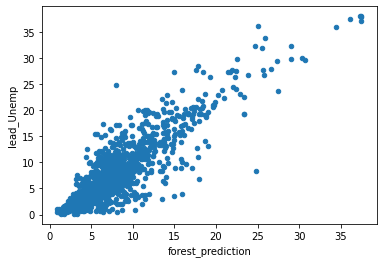

In [21]:
forest_prediction = regr_unemp.predict(x_test_unemp)
forest_predict = pd.DataFrame(forest_prediction, columns=['forest_prediction'])
y_test_frame = y_test_unemp.to_frame()
y_test_frame.head()
y_test_frame.reset_index(inplace=True)
y_test_frame.head()
y_test_frame.drop(columns=['index'], inplace=True)
forest_scatter = pd.concat([forest_predict, y_test_frame], axis=1)
forest_scatter['res'] = forest_scatter['lead_Unemp'] - forest_scatter['forest_prediction']
forest_scatter.plot.scatter(x='forest_prediction', y='lead_Unemp')

In [22]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
#look at parameters used by our current forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

In [23]:
#Now we begin hypertuning our random forest model. We start with a random search over a large parameter grid.

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
from pprint import pprint
pprint(random_grid)

In [25]:
#This code implements the random search.

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_unemp, y_train_unemp)

In [26]:
rf_random.best_params_

In [27]:
rf_random.score(x_test_unemp, y_test_unemp)

In [28]:
rf_random.best_estimator_

In [29]:
#Now, we further refine our hyper-tuning with a grid search localized to parameters near the results of the random search.
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70],
    'max_features': [5,6,7],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1800, 1850, 1900, 1950]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
# Fit the grid search to the data
grid_search.fit(x_train_unemp, y_train_unemp)
grid_search.best_params_

In [31]:
grid_search.score(x_test_unemp, y_test_unemp)

In [32]:
final_model = grid_search.best_estimator_

In [33]:
final_model.feature_importances_

In [22]:
#finally, we save our hyper-tuned machine learning model to a pickle file.
import pickle


filename = 'final_unemp_imputed_model.sav'
#pickle.dump(final_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))